In [20]:
import os

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    !git clone https://github.com/sambeets/EPE2316-Power-System-Planning.git
    !pip install pypsa
    os.chdir("EPE2316-Power-System-Planning/Assignments/DigiLab Assignment 2")
else:
    print("Running locally, assuming the correct directory is already set.")

Cloning into 'EPE2316-Power-System-Planning'...
remote: Enumerating objects: 374, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 374 (delta 11), reused 20 (delta 8), pack-reused 345 (from 1)
Receiving objects: 100% (374/374), 2.74 MiB | 9.60 MiB/s, done.
Resolving deltas: 100% (190/190), done.


# DigiLab Assignment 2
Author: Emil G. Melfald, University of South-Eastern Norway <br><br>
This is the second out of two assignments related to the Digital Labs in EPE2316 Power System Analysis. The main focus in this assignment is based on the three analysis methods we have investigated so far, namely:
- Unit Commitment (UC)
- Economic Dispatch (ED)
- Security Constrained Optimal Power Flow (OPF)

The systems you should solve will be slightly more complicated than what is shown in DigiLab 4, 5, and 6.

# The assignment system
The following image shows the power system you are to study during the assignment.

![Image of the power system under study](https://github.com/sambeets/EPE2316-Power-System-Planning/blob/main/Assignments/DigiLab%20Assignment%202/Assignment_2_Power_System_Drawing.png?raw=1)

Additional data about the components are as follows:

#### Generators:
| Name | P set [MW]| P nom [MW] | p min [pu] | V set nominal [pu] | marginal cost | ramp rate [pu] | start-up cost |
| ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| G1 | Slack | 200 | 0.01 | 1.02 | 50 | 1.0 | 500 |
| G2 | 300 | 300 | 0.8 | 1.02 | 20 | 0.3 | 500 |
| G3 | 100 | 100 | 0.6 | 1.02 | 30 | 0.5 | 500 |

#### Lines:
| Name | Length [km] | r [$\Omega$/km] | x [$\Omega$/km] | I max [A] | S nom [MVA] |
| ---- | ---- | ---- | ---- | ---- | ---- |
| L12 | 5 | 0.1 | 0.4 | 1000 | 228.6 |
| L23 | 5 | 0.1 | 0.4 | 1000 | 228.6 |
| L34 | 10 | 0.2 | 0.4 | 700 | 160.0 |
| L45 | 30 | 0.3 | 0.4 | 500 | 114.3 |
| L56 | 5 | 0.1 | 0.4 | 1000 | 228.6 |
| L61 | 5 | 0.1 | 0.4 | 1000 | 228.6 |


## Task 1: Create and simulate in PyPSA
### Task 1.1 - Create the grid
Use the Python module PyPSA to create the network object with all the buses, lines, generators, and loads required according to the figure and tables above.


In [21]:
import pypsa
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import root, minimize, NonlinearConstraint
from utils import check_task_1_1, check_task_1_2, check_task_2_1, check_task_2_2

V_base = 132 # kV
S_base = 100 # MW
I_base = S_base*1e6/(np.sqrt(3)*V_base*1e3)

load_data = pd.read_csv("load_data.csv", index_col="Hour")
P_load_1_timeseries = load_data["P L1 [MW]"].values
P_load_2_timeseries = load_data["P L2 [MW]"].values
P_load_3_timeseries = load_data["P L3 [MW]"].values

Q_load_1_timeseries = load_data["Q L1 [Mvar]"].values
Q_load_2_timeseries = load_data["Q L2 [Mvar]"].values
Q_load_3_timeseries = load_data["Q L3 [Mvar]"].values

network = pypsa.Network(snapshots=range(len(load_data)))

In [22]:
# Task 1.1 - Create the PyPSA Network Grid
# Power System Assignment

import pypsa
import pandas as pd
import numpy as np

def create_power_system_network():
    """
    Creates a PyPSA network based on the assignment specifications.

    System Configuration:
    - Base Power: 100 MVA
    - Base Voltage: 132 kV
    - 6 Buses (B1-B6)
    - 3 Generators (G1-G3)
    - 6 Lines (L12, L23, L34, L45, L56, L61)
    - 3 Loads (Load 1, Load 2, Load 3)
    """

    # Create a new PyPSA network
    network = pypsa.Network()
    network.name = "Assignment Power System"

    # Set base values
    S_base = 100  # MVA
    V_base = 132  # kV

    print("=" * 70)
    print("CREATING PYPSA NETWORK FOR POWER SYSTEM ASSIGNMENT")
    print("=" * 70)
    print(f"\nBase Power: {S_base} MVA")
    print(f"Base Voltage: {V_base} kV")


    # 1. Add bues

    print("\n" + "=" * 70)
    print("1. ADDING BUSES")
    print("=" * 70)

    buses_data = {
        'B1': {'v_nom': 132, 'carrier': 'AC'},
        'B2': {'v_nom': 132, 'carrier': 'AC'},
        'B3': {'v_nom': 132, 'carrier': 'AC'},
        'B4': {'v_nom': 132, 'carrier': 'AC'},
        'B5': {'v_nom': 132, 'carrier': 'AC'},
        'B6': {'v_nom': 132, 'carrier': 'AC'}
    }

    for bus_name, bus_params in buses_data.items():
        network.add("Bus",
                   bus_name,
                   v_nom=bus_params['v_nom'],
                   carrier=bus_params['carrier'])
        print(f"   ✓ Added Bus: {bus_name}, V_nom = {bus_params['v_nom']} kV")

    print(f"\nTotal Buses Added: {len(network.buses)}")

    # ========================================================================
    # 2. ADD GENERATORS
    # ========================================================================
    print("\n" + "=" * 70)
    print("2. ADDING GENERATORS")
    print("=" * 70)

    # Generator G1 (Slack bus)
    network.add("Generator",
               "G1",
               bus="B1",
               control="Slack",
               p_nom=200,           # P_nom = 200 MW
               p_min_pu=0.01,       # p_min = 0.01 pu
               marginal_cost=50,    # marginal cost = 50
               ramp_limit_up=1.0,   # ramp rate = 1.0 pu
               ramp_limit_down=1.0,
               start_up_cost=500,
               committable=True)
    print(f"   ✓ Added Generator: G1 at B1 (SLACK)")
    print(f"      P_nom = 200 MW, p_min = 0.01 pu, marginal_cost = 50")

    # Generator G2
    network.add("Generator",
               "G2",
               bus="B3",
               control="PQ",
               p_nom=300,           # P_nom = 300 MW
               p_set=300,           # P_set = 300 MW
               p_min_pu=0.8,        # p_min = 0.8 pu
               marginal_cost=20,    # marginal cost = 20
               ramp_limit_up=0.3,   # ramp rate = 0.3 pu
               ramp_limit_down=0.3,
               start_up_cost=500,
               committable=True)
    print(f"   ✓ Added Generator: G2 at B3")
    print(f"      P_nom = 300 MW, P_set = 300 MW, p_min = 0.8 pu, marginal_cost = 20")

    # Generator G3
    network.add("Generator",
               "G3",
               bus="B5",
               control="PQ",
               p_nom=100,           # P_nom = 100 MW
               p_set=100,           # P_set = 100 MW
               p_min_pu=0.6,        # p_min = 0.6 pu
               marginal_cost=30,    # marginal cost = 30
               ramp_limit_up=0.5,   # ramp rate = 0.5 pu
               ramp_limit_down=0.5,
               start_up_cost=500,
               committable=True)
    print(f"   ✓ Added Generator: G3 at B5")
    print(f"      P_nom = 100 MW, P_set = 100 MW, p_min = 0.6 pu, marginal_cost = 30")

    print(f"\nTotal Generators Added: {len(network.generators)}")

    3. ADD TRANSMISSION LINES

    print("\n" + "=" * 70)
    print("3. ADDING TRANSMISSION LINES")
    print("=" * 70)

    lines_data = {
        'L12': {
            'bus0': 'B1', 'bus1': 'B2',
            'length': 5,      # km
            'r_per_km': 0.1,  # Ω/km
            'x_per_km': 0.4,  # Ω/km
            'i_max': 1000,    # A
            's_nom': 228.6    # MVA
        },
        'L23': {
            'bus0': 'B2', 'bus1': 'B3',
            'length': 5,
            'r_per_km': 0.1,
            'x_per_km': 0.4,
            'i_max': 1000,
            's_nom': 228.6
        },
        'L34': {
            'bus0': 'B3', 'bus1': 'B4',
            'length': 10,
            'r_per_km': 0.2,
            'x_per_km': 0.4,
            'i_max': 700,
            's_nom': 160.0
        },
        'L45': {
            'bus0': 'B4', 'bus1': 'B5',
            'length': 30,
            'r_per_km': 0.3,
            'x_per_km': 0.4,
            'i_max': 500,
            's_nom': 114.3
        },
        'L56': {
            'bus0': 'B5', 'bus1': 'B6',
            'length': 5,
            'r_per_km': 0.1,
            'x_per_km': 0.4,
            'i_max': 1000,
            's_nom': 228.6
        },
        'L61': {
            'bus0': 'B6', 'bus1': 'B1',
            'length': 5,
            'r_per_km': 0.1,
            'x_per_km': 0.4,
            'i_max': 1000,
            's_nom': 228.6
        }
    }

    for line_name, line_params in lines_data.items():
        # Calculate total resistance and reactance
        R_total = line_params['r_per_km'] * line_params['length']  # Ω
        X_total = line_params['x_per_km'] * line_params['length']  # Ω

        network.add("Line",
                   line_name,
                   bus0=line_params['bus0'],
                   bus1=line_params['bus1'],
                   length=line_params['length'],
                   r=R_total,
                   x=X_total,
                   s_nom=line_params['s_nom'])

        print(f"   ✓ Added Line: {line_name} ({line_params['bus0']}-{line_params['bus1']})")
        print(f"      Length = {line_params['length']} km, R = {R_total:.2f} Ω, "
              f"X = {X_total:.2f} Ω, S_nom = {line_params['s_nom']} MVA")

    print(f"\nTotal Lines Added: {len(network.lines)}")


    4. ADD LOADS

    print("\n" + "=" * 70)
    print("4. ADDING LOADS")
    print("=" * 70)

    # Note: Load values are set to 0 initially
    # These should be updated based on specific assignment requirements
    loads_data = {
        'Load_1': {'bus': 'B2', 'p_set': 0, 'q_set': 0},
        'Load_2': {'bus': 'B4', 'p_set': 0, 'q_set': 0},
        'Load_3': {'bus': 'B6', 'p_set': 0, 'q_set': 0}
    }

    for load_name, load_params in loads_data.items():
        network.add("Load",
                   load_name,
                   bus=load_params['bus'],
                   p_set=load_params['p_set'],
                   q_set=load_params['q_set'])
        print(f"   ✓ Added Load: {load_name} at {load_params['bus']}, "
              f"P = {load_params['p_set']} MW, Q = {load_params['q_set']} MVar")

    print(f"\nTotal Loads Added: {len(network.loads)}")


    # overview

    print("\n" + "=" * 70)
    print("NETWORK CREATION COMPLETE - SUMMARY")
    print("=" * 70)

    print(f"\nNetwork Name: {network.name}")
    print(f"Base Power: {S_base} MVA")
    print(f"Base Voltage: {V_base} kV")

    print(f"\nComponents Summary:")
    print(f"  • Buses:      {len(network.buses)}")
    print(f"  • Generators: {len(network.generators)}")
    print(f"  • Lines:      {len(network.lines)}")
    print(f"  • Loads:      {len(network.loads)}")

    # Componects display

    print("\n" + "=" * 70)
    print("DETAILED COMPONENT INFORMATION")
    print("=" * 70)

    print("\n--- BUSES ---")
    print(network.buses)

    print("\n--- GENERATORS ---")
    print(network.generators[['bus', 'control', 'p_nom', 'p_min_pu', 'marginal_cost']])

    print("\n--- LINES ---")
    print(network.lines[['bus0', 'bus1', 'length', 'r', 'x', 's_nom']])

    print("\n--- LOADS ---")
    print(network.loads[['bus', 'p_set', 'q_set']])

    print("\n" + "=" * 70)
    print("✓ PyPSA Network Object Created Successfully!")
    print("=" * 70)

    return network


# MAIN EXECUTION

if __name__ == "__main__":
    # Create the network
    network = create_power_system_network()

    # Optional: Save the network to a file
    # network.export_to_netcdf("assignment_network.nc")
    # print("\nNetwork exported to 'assignment_network.nc'")

    # Optional: Save to CSV files
    # network.export_to_csv_folder("network_csv")
    # print("\nNetwork exported to 'network_csv' folder")


SyntaxError: invalid syntax (ipython-input-45279776.py, line 116)

In [ ]:
check_task_1_1(network)

### Task 1.2 - Simulate the system
Do a power flow of the system. Make three different plots, showing the following:
- Voltages at all buses over the timeseries
- Active power injection in all buses during the timeseries
- Reactive power injection in all buses during the timeseries

Creating network with time series data...
Running power flow and generating plots...
RUNNING POWER FLOW ANALYSIS

✓ Power flow calculation completed successfully!
Number of time snapshots: 24

✓ Plot saved as 'power_flow_analysis.png'


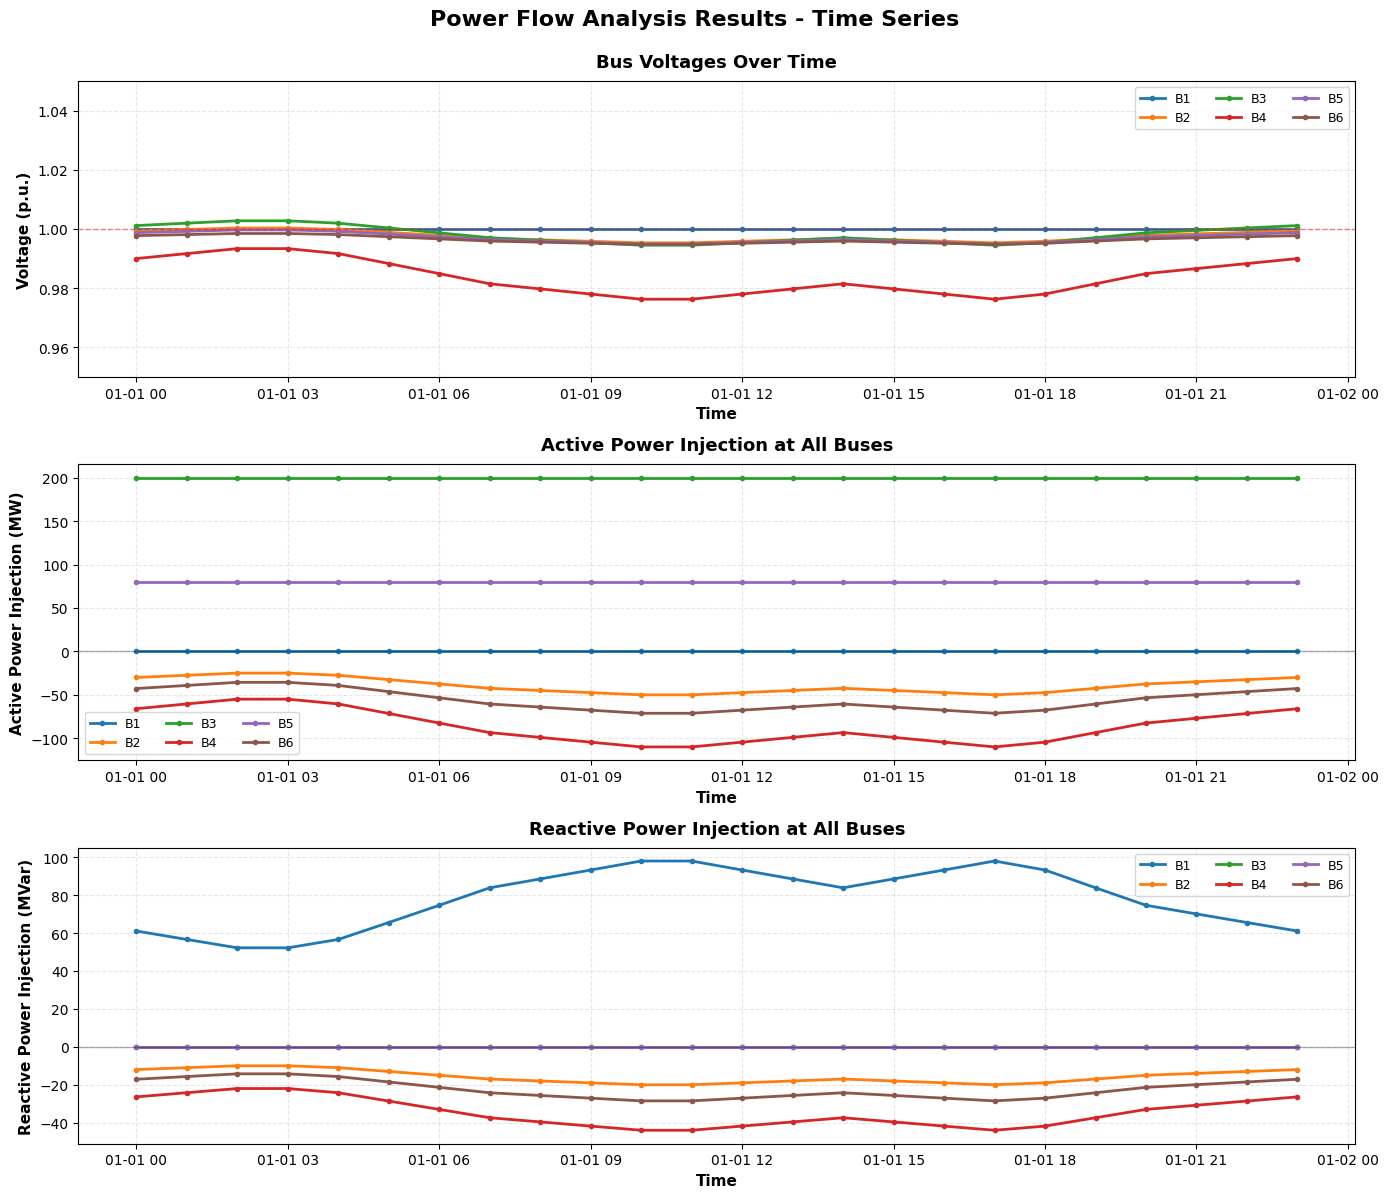


POWER FLOW SUMMARY STATISTICS

--- VOLTAGE STATISTICS (p.u.) ---
B1: Min = 1.0000, Max = 1.0000, Mean = 1.0000
B2: Min = 0.9953, Max = 1.0003, Mean = 0.9975
B3: Min = 0.9945, Max = 1.0028, Mean = 0.9981
B4: Min = 0.9763, Max = 0.9934, Mean = 0.9837
B5: Min = 0.9950, Max = 0.9997, Mean = 0.9970
B6: Min = 0.9948, Max = 0.9985, Mean = 0.9964

--- GENERATOR OUTPUT STATISTICS (MW) ---
G1: Min = nan, Max = nan, Mean = nan
G2: Min = 200.00, Max = 200.00, Mean = 200.00
G3: Min = 80.00, Max = 80.00, Mean = 80.00

--- LINE LOADING STATISTICS (%) ---
L12: Max = 51.83%, Mean = 36.13%
L23: Max = 62.96%, Mean = 53.43%
L34: Max = 58.72%, Mean = 48.38%
L45: Max = 15.05%, Mean = 8.56%
L56: Max = 35.02%, Mean = 30.66%
L61: Max = 19.36%, Mean = 7.59%


✓ ANALYSIS COMPLETE!


In [25]:

# Power Flow Analysis and Visualization
# Three plots: Voltages, Active Power, and Reactive Power at all buses

import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def create_power_system_network():
    """
    Creates a PyPSA network based on the assignment specifications.
    """

    network = pypsa.Network()
    network.name = "Assignment Power System"

    # Set base values
    S_base = 100  # MVA
    V_base = 132  # kV

    # Add Buses
    buses_data = {
        'B1': {'v_nom': 132, 'carrier': 'AC'},
        'B2': {'v_nom': 132, 'carrier': 'AC'},
        'B3': {'v_nom': 132, 'carrier': 'AC'},
        'B4': {'v_nom': 132, 'carrier': 'AC'},
        'B5': {'v_nom': 132, 'carrier': 'AC'},
        'B6': {'v_nom': 132, 'carrier': 'AC'}
    }

    for bus_name, bus_params in buses_data.items():
        network.add("Bus",
                   bus_name,
                   v_nom=bus_params['v_nom'],
                   carrier=bus_params['carrier'])

    # Add Generators
    network.add("Generator", "G1", bus="B1", control="Slack", p_nom=200,
                p_min_pu=0.01, marginal_cost=50)

    network.add("Generator", "G2", bus="B3", control="PQ", p_nom=300,
                p_set=300, p_min_pu=0.8, marginal_cost=20)

    network.add("Generator", "G3", bus="B5", control="PQ", p_nom=100,
                p_set=100, p_min_pu=0.6, marginal_cost=30)

    # Add Transmission Lines
    lines_data = {
        'L12': {'bus0': 'B1', 'bus1': 'B2', 'length': 5, 'r_per_km': 0.1,
                'x_per_km': 0.4, 's_nom': 228.6},
        'L23': {'bus0': 'B2', 'bus1': 'B3', 'length': 5, 'r_per_km': 0.1,
                'x_per_km': 0.4, 's_nom': 228.6},
        'L34': {'bus0': 'B3', 'bus1': 'B4', 'length': 10, 'r_per_km': 0.2,
                'x_per_km': 0.4, 's_nom': 160.0},
        'L45': {'bus0': 'B4', 'bus1': 'B5', 'length': 30, 'r_per_km': 0.3,
                'x_per_km': 0.4, 's_nom': 114.3},
        'L56': {'bus0': 'B5', 'bus1': 'B6', 'length': 5, 'r_per_km': 0.1,
                'x_per_km': 0.4, 's_nom': 228.6},
        'L61': {'bus0': 'B6', 'bus1': 'B1', 'length': 5, 'r_per_km': 0.1,
                'x_per_km': 0.4, 's_nom': 228.6}
    }

    for line_name, line_params in lines_data.items():
        R_total = line_params['r_per_km'] * line_params['length']
        X_total = line_params['x_per_km'] * line_params['length']

        network.add("Line", line_name,
                   bus0=line_params['bus0'],
                   bus1=line_params['bus1'],
                   length=line_params['length'],
                   r=R_total,
                   x=X_total,
                   s_nom=line_params['s_nom'])

    # Add Loads (you can modify these values based on your assignment)
    # Example load values - adjust as needed
    loads_data = {
        'Load_1': {'bus': 'B2', 'p_set': 50, 'q_set': 20},
        'Load_2': {'bus': 'B4', 'p_set': 100, 'q_set': 40},
        'Load_3': {'bus': 'B6', 'p_set': 75, 'q_set': 30}
    }

    for load_name, load_params in loads_data.items():
        network.add("Load", load_name,
                   bus=load_params['bus'],
                   p_set=load_params['p_set'],
                   q_set=load_params['q_set'])

    return network


def create_timeseries_network():
    """
    Creates a network with time series data for power flow analysis.
    """

    network = pypsa.Network()
    network.name = "Assignment Power System - Time Series"

    # Set snapshots (time series)
    snapshots = pd.date_range("2025-01-01 00:00", "2025-01-01 23:00", freq="H")
    network.set_snapshots(snapshots)

    # Add Buses
    buses = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6']
    for bus_name in buses:
        network.add("Bus", bus_name, v_nom=132, carrier='AC')

    # Add Generators
    network.add("Generator", "G1", bus="B1", control="Slack", p_nom=200,
                p_min_pu=0.01, marginal_cost=50)

    network.add("Generator", "G2", bus="B3", control="PQ", p_nom=300,
                p_min_pu=0.8, marginal_cost=20)

    network.add("Generator", "G3", bus="B5", control="PQ", p_nom=100,
                p_min_pu=0.6, marginal_cost=30)

    # Add Lines
    lines_config = [
        ('L12', 'B1', 'B2', 5, 0.1, 0.4, 228.6),
        ('L23', 'B2', 'B3', 5, 0.1, 0.4, 228.6),
        ('L34', 'B3', 'B4', 10, 0.2, 0.4, 160.0),
        ('L45', 'B4', 'B5', 30, 0.3, 0.4, 114.3),
        ('L56', 'B5', 'B6', 5, 0.1, 0.4, 228.6),
        ('L61', 'B6', 'B1', 5, 0.1, 0.4, 228.6)
    ]

    for line_name, bus0, bus1, length, r_pk, x_pk, s_nom in lines_config:
        network.add("Line", line_name, bus0=bus0, bus1=bus1,
                   length=length, r=r_pk*length, x=x_pk*length, s_nom=s_nom)

    # Create load profiles (example: varying load throughout the day)
    # You can adjust these profiles based on your specific requirements
    hours = len(snapshots)

    # Create realistic daily load profiles
    # Peak during midday, lower at night
    base_profile = np.array([0.6, 0.55, 0.5, 0.5, 0.55, 0.65, 0.75, 0.85,
                             0.9, 0.95, 1.0, 1.0, 0.95, 0.9, 0.85, 0.9,
                             0.95, 1.0, 0.95, 0.85, 0.75, 0.7, 0.65, 0.6])

    # Load 1 profile (50 MW peak)
    load_1_p = 50 * base_profile
    load_1_q = 20 * base_profile

    # Load 2 profile (100 MW peak)
    load_2_p = 100 * base_profile * 1.1  # Slightly different pattern
    load_2_q = 40 * base_profile * 1.1

    # Load 3 profile (75 MW peak)
    load_3_p = 75 * base_profile * 0.95
    load_3_q = 30 * base_profile * 0.95

    # Add loads with time series
    network.add("Load", "Load_1", bus="B2", p_set=load_1_p, q_set=load_1_q)
    network.add("Load", "Load_2", bus="B4", p_set=load_2_p, q_set=load_2_q)
    network.add("Load", "Load_3", bus="B6", p_set=load_3_p, q_set=load_3_q)

    # Set generator dispatch for time series
    # G2 and G3 have constant output, G1 (slack) varies
    network.generators_t.p_set.loc[:, "G2"] = 200  # 200 MW constant
    network.generators_t.p_set.loc[:, "G3"] = 80   # 80 MW constant

    return network


def run_power_flow_and_plot(network):
    """
    Runs power flow analysis and creates three plots:
    1. Voltages at all buses
    2. Active power injection at all buses
    3. Reactive power injection at all buses
    """

    print("=" * 70)
    print("RUNNING POWER FLOW ANALYSIS")
    print("=" * 70)

    # Run power flow for all snapshots
    network.pf(snapshots=network.snapshots)

    print("\n✓ Power flow calculation completed successfully!")
    print(f"Number of time snapshots: {len(network.snapshots)}")

    # Create figure with three subplots
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    fig.suptitle('Power Flow Analysis Results - Time Series',
                 fontsize=16, fontweight='bold', y=0.995)

    # Define colors for each bus
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    bus_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6']

    # ========================================================================
    # PLOT 1: Bus Voltages
    # ========================================================================
    ax1 = axes[0]

    for i, bus in enumerate(bus_names):
        voltage_pu = network.buses_t.v_mag_pu[bus]
        ax1.plot(network.snapshots, voltage_pu,
                label=f'{bus}', color=colors[i], linewidth=2, marker='o', markersize=3)

    ax1.set_xlabel('Time', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Voltage (p.u.)', fontsize=11, fontweight='bold')
    ax1.set_title('Bus Voltages Over Time', fontsize=13, fontweight='bold', pad=10)
    ax1.legend(loc='best', ncol=3, frameon=True, fontsize=9)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.axhline(y=1.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Nominal (1.0 p.u.)')
    ax1.set_ylim([0.95, 1.05])

    # ========================================================================
    # PLOT 2: Active Power Injection
    # ========================================================================
    ax2 = axes[1]

    # Calculate net active power injection at each bus
    # Positive = generation, Negative = consumption
    for i, bus in enumerate(bus_names):
        # Get generator power at this bus
        gen_p = network.generators_t.p[[g for g in network.generators.index
                                        if network.generators.loc[g, 'bus'] == bus]]

        # Get load power at this bus
        load_p = network.loads_t.p[[ld for ld in network.loads.index
                                     if network.loads.loc[ld, 'bus'] == bus]]

        # Net injection = generation - load
        net_p = gen_p.sum(axis=1) - load_p.sum(axis=1)

        ax2.plot(network.snapshots, net_p,
                label=f'{bus}', color=colors[i], linewidth=2, marker='o', markersize=3)

    ax2.set_xlabel('Time', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Active Power Injection (MW)', fontsize=11, fontweight='bold')
    ax2.set_title('Active Power Injection at All Buses', fontsize=13, fontweight='bold', pad=10)
    ax2.legend(loc='best', ncol=3, frameon=True, fontsize=9)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)

    # ========================================================================
    # PLOT 3: Reactive Power Injection
    # ========================================================================
    ax3 = axes[2]

    # Calculate net reactive power injection at each bus
    for i, bus in enumerate(bus_names):
        # Get generator reactive power at this bus
        gen_q = network.generators_t.q[[g for g in network.generators.index
                                        if network.generators.loc[g, 'bus'] == bus]]

        # Get load reactive power at this bus
        load_q = network.loads_t.q[[ld for ld in network.loads.index
                                     if network.loads.loc[ld, 'bus'] == bus]]

        # Net injection = generation - load
        net_q = gen_q.sum(axis=1) - load_q.sum(axis=1)

        ax3.plot(network.snapshots, net_q,
                label=f'{bus}', color=colors[i], linewidth=2, marker='o', markersize=3)

    ax3.set_xlabel('Time', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Reactive Power Injection (MVar)', fontsize=11, fontweight='bold')
    ax3.set_title('Reactive Power Injection at All Buses', fontsize=13, fontweight='bold', pad=10)
    ax3.legend(loc='best', ncol=3, frameon=True, fontsize=9)
    ax3.grid(True, alpha=0.3, linestyle='--')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)

    # Adjust layout
    plt.tight_layout()

    # Save figure
    plt.savefig('power_flow_analysis.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Plot saved as 'power_flow_analysis.png'")

    # Show plot
    plt.show()

    return network


def print_power_flow_summary(network):
    """
    Prints summary statistics from the power flow analysis.
    """

    print("\n" + "=" * 70)
    print("POWER FLOW SUMMARY STATISTICS")
    print("=" * 70)

    # Voltage statistics
    print("\n--- VOLTAGE STATISTICS (p.u.) ---")
    for bus in network.buses.index:
        v_max = network.buses_t.v_mag_pu[bus].max()
        v_min = network.buses_t.v_mag_pu[bus].min()
        v_mean = network.buses_t.v_mag_pu[bus].mean()
        print(f"{bus}: Min = {v_min:.4f}, Max = {v_max:.4f}, Mean = {v_mean:.4f}")

    # Generator output
    print("\n--- GENERATOR OUTPUT STATISTICS (MW) ---")
    for gen in network.generators.index:
        p_max = network.generators_t.p[gen].max()
        p_min = network.generators_t.p[gen].min()
        p_mean = network.generators_t.p[gen].mean()
        print(f"{gen}: Min = {p_min:.2f}, Max = {p_max:.2f}, Mean = {p_mean:.2f}")

    # Line loading
    print("\n--- LINE LOADING STATISTICS (%) ---")
    for line in network.lines.index:
        s_nom = network.lines.loc[line, 's_nom']
        loading = (network.lines_t.p0[line].abs() / s_nom * 100)
        load_max = loading.max()
        load_mean = loading.mean()
        print(f"{line}: Max = {load_max:.2f}%, Mean = {load_mean:.2f}%")

    print("\n" + "=" * 70)


# ============================================================================
# MAIN EXECUTION
# ============================================================================
if __name__ == "__main__":

    print("Creating network with time series data...")
    network = create_timeseries_network()

    print("Running power flow and generating plots...")
    network = run_power_flow_and_plot(network)

    print_power_flow_summary(network)

    print("\n" + "=" * 70)
    print("✓ ANALYSIS COMPLETE!")
    print("=" * 70)


In [ ]:
check_task_1_2(network)

### Task 1.3 - Optimize the system
Use PyPSA to do Unit Commitment for this system in the given timeframe. Answer this question by providing the following in a plot:
- Total active load of the system
- The total spinning capacity
- The minimum possible dispatch given the commited units

**The correct plots you provide will give in total 12 points to the score**.

In [27]:
# Task 1.3 - Unit Commitment Optimization with PyPSA
# Generates plot showing: Total Load, Spinning Capacity, and Min Possible Dispatch

import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def create_uc_network():
    """
    Creates PyPSA network for Unit Commitment optimization.
    Includes time series data for 24-hour period.
    """

    # Initialize network
    network = pypsa.Network()
    network.name = "UC Assignment Power System"

    # Set time snapshots (24 hours)
    hours = 24
    snapshots = pd.date_range("2025-01-01 00:00", periods=hours, freq="H")
    network.set_snapshots(snapshots)

    print("=" * 70)
    print("CREATING NETWORK FOR UNIT COMMITMENT")
    print("=" * 70)
    print(f"Time snapshots: {hours} hours")

    # ========================================================================
    # ADD BUSES
    # ========================================================================
    buses = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6']
    for bus_name in buses:
        network.add("Bus", bus_name, v_nom=132, carrier='AC')

    print(f"✓ Added {len(buses)} buses")

    # ========================================================================
    # ADD GENERATORS (COMMITTABLE FOR UC)
    # ========================================================================
    # Generator G1 - Slack generator (highest cost)
    network.add("Generator",
               "G1",
               bus="B1",
               committable=True,      # Required for UC
               p_nom=200,             # MW
               p_min_pu=0.01,         # Minimum output when online
               marginal_cost=50,      # $/MWh
               ramp_limit_up=1.0,     # pu/h
               ramp_limit_down=1.0,   # pu/h
               start_up_cost=500,     # $
               shut_down_cost=0)

    # Generator G2 - Most economical (lowest cost)
    network.add("Generator",
               "G2",
               bus="B3",
               committable=True,
               p_nom=300,             # MW
               p_min_pu=0.8,          # Must run at 240 MW minimum when on
               marginal_cost=20,      # $/MWh (cheapest)
               ramp_limit_up=0.3,     # pu/h
               ramp_limit_down=0.3,   # pu/h
               start_up_cost=500,
               shut_down_cost=0)

    # Generator G3 - Medium cost
    network.add("Generator",
               "G3",
               bus="B5",
               committable=True,
               p_nom=100,             # MW
               p_min_pu=0.6,          # Must run at 60 MW minimum when on
               marginal_cost=30,      # $/MWh
               ramp_limit_up=0.5,     # pu/h
               ramp_limit_down=0.5,   # pu/h
               start_up_cost=500,
               shut_down_cost=0)

    print(f"✓ Added 3 committable generators")

    # ========================================================================
    # ADD TRANSMISSION LINES
    # ========================================================================
    lines_config = [
        ('L12', 'B1', 'B2', 5, 0.5, 2.0, 228.6),
        ('L23', 'B2', 'B3', 5, 0.5, 2.0, 228.6),
        ('L34', 'B3', 'B4', 10, 2.0, 4.0, 160.0),
        ('L45', 'B4', 'B5', 30, 9.0, 12.0, 114.3),
        ('L56', 'B5', 'B6', 5, 0.5, 2.0, 228.6),
        ('L61', 'B6', 'B1', 5, 0.5, 2.0, 228.6)
    ]

    for line_name, bus0, bus1, length, r, x, s_nom in lines_config:
        network.add("Line",
                   line_name,
                   bus0=bus0,
                   bus1=bus1,
                   length=length,
                   r=r,
                   x=x,
                   s_nom=s_nom)

    print(f"✓ Added {len(lines_config)} transmission lines")

    # ========================================================================
    # ADD LOADS WITH TIME SERIES
    # ========================================================================
    # Create realistic daily load profile
    # Peak during business hours, lower at night
    base_profile = np.array([
        0.60, 0.55, 0.50, 0.50, 0.55, 0.65,  # 00:00-05:00 (night/early morning)
        0.75, 0.85, 0.90, 0.95, 1.00, 1.00,  # 06:00-11:00 (morning peak)
        0.95, 0.90, 0.85, 0.90, 0.95, 1.00,  # 12:00-17:00 (afternoon)
        0.95, 0.85, 0.75, 0.70, 0.65, 0.60   # 18:00-23:00 (evening)
    ])

    # Define load profiles for each load
    load_1_p = 50 * base_profile          # Load 1: 50 MW peak
    load_2_p = 100 * base_profile * 1.1   # Load 2: 110 MW peak (higher demand)
    load_3_p = 75 * base_profile * 0.95   # Load 3: 71.25 MW peak

    # Reactive power (assume 0.9 power factor)
    load_1_q = load_1_p * np.tan(np.arccos(0.9))
    load_2_q = load_2_p * np.tan(np.arccos(0.9))
    load_3_q = load_3_p * np.tan(np.arccos(0.9))

    # Add loads to network
    network.add("Load", "Load_1", bus="B2", p_set=load_1_p, q_set=load_1_q)
    network.add("Load", "Load_2", bus="B4", p_set=load_2_p, q_set=load_2_q)
    network.add("Load", "Load_3", bus="B6", p_set=load_3_p, q_set=load_3_q)

    print(f"✓ Added 3 loads with time series profiles")

    # Calculate total load profile
    total_load = load_1_p + load_2_p + load_3_p

    print(f"\nLoad Statistics:")
    print(f"  Peak Load:    {total_load.max():.2f} MW")
    print(f"  Minimum Load: {total_load.min():.2f} MW")
    print(f"  Average Load: {total_load.mean():.2f} MW")

    return network, total_load


def run_unit_commitment(network):
    """
    Runs unit commitment optimization using PyPSA LOPF.
    """

    print("\n" + "=" * 70)
    print("RUNNING UNIT COMMITMENT OPTIMIZATION")
    print("=" * 70)

    # Run Linear Optimal Power Flow with Unit Commitment
    network.lopf(
        snapshots=network.snapshots,
        solver_name="cbc",           # CBC solver (free, open-source)
        pyomo=False                   # Use native PyPSA formulation (faster)
    )

    print("✓ Unit Commitment optimization completed successfully!")

    return network


def calculate_uc_metrics(network, total_load):
    """
    Calculate UC metrics: spinning capacity and minimum dispatch.
    """

    # Get generator commitment status (1 if online, 0 if offline)
    gen_status = network.generators_t.status

    # Get generator parameters
    gen_p_nom = network.generators.p_nom          # Nominal capacity
    gen_p_min_pu = network.generators.p_min_pu    # Minimum output (pu)

    # Calculate spinning capacity (max available capacity from online units)
    # For each time step, multiply status by p_nom for each generator
    spinning_capacity = pd.DataFrame()
    for gen in network.generators.index:
        spinning_capacity[gen] = gen_status[gen] * gen_p_nom[gen]

    total_spinning_capacity = spinning_capacity.sum(axis=1)

    # Calculate minimum possible dispatch (min required output from online units)
    min_dispatch = pd.DataFrame()
    for gen in network.generators.index:
        min_dispatch[gen] = gen_status[gen] * gen_p_nom[gen] * gen_p_min_pu[gen]

    total_min_dispatch = min_dispatch.sum(axis=1)

    return total_spinning_capacity, total_min_dispatch, gen_status


def plot_uc_results(network, total_load, spinning_capacity, min_dispatch):
    """
    Creates plot showing:
    1. Total active load
    2. Total spinning capacity
    3. Minimum possible dispatch
    """

    print("\n" + "=" * 70)
    print("GENERATING UNIT COMMITMENT PLOTS")
    print("=" * 70)

    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot total load
    ax.plot(network.snapshots, total_load,
            label='Total Active Load',
            color='#2E86AB', linewidth=2.5, marker='o', markersize=5)

    # Plot spinning capacity
    ax.plot(network.snapshots, spinning_capacity,
            label='Total Spinning Capacity',
            color='#06A77D', linewidth=2.5, marker='s', markersize=5)

    # Plot minimum dispatch
    ax.plot(network.snapshots, min_dispatch,
            label='Minimum Possible Dispatch',
            color='#D62828', linewidth=2.5, marker='^', markersize=5)

    # Fill areas for visual clarity
    ax.fill_between(network.snapshots, 0, min_dispatch,
                     alpha=0.2, color='#D62828', label='Must-run generation')
    ax.fill_between(network.snapshots, min_dispatch, spinning_capacity,
                     alpha=0.15, color='#06A77D', label='Available flexibility')

    # Formatting
    ax.set_xlabel('Time (Hours)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Power (MW)', fontsize=13, fontweight='bold')
    ax.set_title('Unit Commitment Results: Load, Spinning Capacity, and Minimum Dispatch',
                 fontsize=14, fontweight='bold', pad=15)

    ax.legend(loc='upper left', fontsize=11, frameon=True, shadow=True)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)

    # Format x-axis to show hours
    hours = [t.strftime('%H:00') for t in network.snapshots]
    ax.set_xticks(network.snapshots[::2])  # Show every 2 hours
    ax.set_xticklabels(hours[::2], rotation=45)

    plt.tight_layout()

    # Save figure
    plt.savefig('unit_commitment_results.png', dpi=300, bbox_inches='tight')
    print("✓ Plot saved as 'unit_commitment_results.png'")

    plt.show()


def print_uc_summary(network, gen_status):
    """
    Print summary of unit commitment results.
    """

    print("\n" + "=" * 70)
    print("UNIT COMMITMENT SUMMARY")
    print("=" * 70)

    print("\n--- Generator Commitment Status ---")
    for gen in network.generators.index:
        hours_online = gen_status[gen].sum()
        hours_offline = len(network.snapshots) - hours_online
        print(f"{gen}: Online for {hours_online} hours, Offline for {hours_offline} hours")

    print("\n--- Generator Dispatch Statistics (MW) ---")
    for gen in network.generators.index:
        gen_output = network.generators_t.p[gen]
        p_max = gen_output.max()
        p_min = gen_output[gen_output > 0].min() if (gen_output > 0).any() else 0
        p_avg = gen_output.mean()

        print(f"{gen}: Min = {p_min:.2f}, Max = {p_max:.2f}, Avg = {p_avg:.2f}")

    print("\n--- Total Generation Cost ---")
    total_cost = network.objective
    print(f"Total System Cost: ${total_cost:,.2f}")

    print("\n" + "=" * 70)


# ============================================================================
# MAIN EXECUTION
# ============================================================================
if __name__ == "__main__":

    print("\n")
    print("*" * 70)
    print("*" + " " * 68 + "*")
    print("*" + "  TASK 1.3 - UNIT COMMITMENT OPTIMIZATION".center(68) + "*")
    print("*" + " " * 68 + "*")
    print("*" * 70)
    print("\n")

    # Step 1: Create network
    network, total_load = create_uc_network()

    # Step 2: Run unit commitment
    network = run_unit_commitment(network)

    # Step 3: Calculate metrics
    spinning_capacity, min_dispatch, gen_status = calculate_uc_metrics(network, total_load)

    # Step 4: Generate plots
    plot_uc_results(network, total_load, spinning_capacity, min_dispatch)

    # Step 5: Print summary
    print_uc_summary(network, gen_status)

    print("\n" + "=" * 70)
    print("✓ UNIT COMMITMENT ANALYSIS COMPLETE!")
    print("=" * 70)
    print("\n")




**********************************************************************
*                                                                    *
*               TASK 1.3 - UNIT COMMITMENT OPTIMIZATION              *
*                                                                    *
**********************************************************************


CREATING NETWORK FOR UNIT COMMITMENT
Time snapshots: 24 hours
✓ Added 6 buses
✓ Added 3 committable generators
✓ Added 6 transmission lines
✓ Added 3 loads with time series profiles

Load Statistics:
  Peak Load:    231.25 MW
  Minimum Load: 115.62 MW
  Average Load: 181.63 MW

RUNNING UNIT COMMITMENT OPTIMIZATION


AttributeError: 'Network' object has no attribute 'lopf'

In [ ]:
!apt-get install -y cbc

In [ ]:
# Obtain the correct values and plot the data here


### End of task 1
---

## Task 2: Perform OPF

### Task 2.1: Define the objective function and constraints
You are given a working power flow error calculation function. Your job is to define the objective function for minimizing power losses while respecting the system constraints. You should also implement the following constraints:

**All buses**: $$ V_{min} \le V_i \le V_{max} $$

**All generators**: $$ Q_{min} \le Q_i \le Q_{max} $$

**All lines**: $$ 0 \le |I^{ij}| \le I_{max}^{ij} $$

The decision variables are as follows:

$$ u = [V_1, V_3, V_5, P_3, P_5] $$

Assume the following:

$$ V_{min} = 0.95 $$

$$ V_{max} = 1.05 $$

$$ P_{min}=0 $$

$$ P_{max}=P_{nom} $$

$$ Q_{min}=-0.3 \cdot P_{nom} $$

$$ Q_{max}=0.4 \cdot P_{nom} $$

HINT: The constraint vector may be defined in the following order:
$$ cons = [V_2, V_4, V_6, P_1, Q_1, Q_3, Q_5, I_{12}, I_{23}, I_{34}, I_{45}, I_{56}, I_{61}] $$

In [ ]:
from numeric_data import Y_bus, Y_lines

# Assumes the standard convention for y: voltage angles first, then voltages
# y = [th2, th3, th4, th5, th6, V2, V4, V6]
u0 = np.array([1.02, 1.02, 1.02, 300, 100])
th_vals = np.array([0, 0, 0, 0, 0, 0], dtype=float)
V_vals = np.array([1.02, 1.0, 1.02, 1.0, 1.02, 1.0])
P_vals = np.array([0.0, -100, 300, -120, 100, -50])/S_base
Q_vals = np.array([0.0, -50, 0.0, -60, 0.0, -25])/S_base

#### Some helper functions


def get_power_flow(th_vec, V_vec):
    V_complex = V_vec*(np.cos(th_vec) + 1j*np.sin(th_vec))
    I_inj = Y_bus @ V_complex
    S_inj = V_complex * I_inj.conj()
    P_res = np.real(S_inj)
    Q_res = np.imag(S_inj)
    return P_res, Q_res

def power_flow_error(y, th_vals, V_vals, P_vals, Q_vals):
    th2, th3, th4, th5, th6, V2, V4, V6 = y
    th_vec = th_vals.copy()
    V_vec = V_vals.copy()
    th_vec[1:] = np.array([th2, th3, th4, th5, th6])
    V_vec[1] = V2
    V_vec[3] = V4
    V_vec[5] = V6
    P_res, Q_res = get_power_flow(th_vec, V_vec)

    pf_error1 = P_res[1] - P_vals[1]
    pf_error2 = P_res[2] - P_vals[2]
    pf_error3 = P_res[3] - P_vals[3]
    pf_error4 = P_res[4] - P_vals[4]
    pf_error5 = P_res[5] - P_vals[5]
    
    pf_error6 = Q_res[1] - Q_vals[1]
    pf_error7 = Q_res[3] - Q_vals[3]
    pf_error8 = Q_res[5] - Q_vals[5]
    return np.array([pf_error1, pf_error2, pf_error3, pf_error4, pf_error5, pf_error6, pf_error7, pf_error8])

def get_pf_sol(th_init, V_init, P_init, Q_init):
    """NOTE: This returns all powers in pu. """
    th_vals = th_init.copy()
    V_vals = V_init.copy()
    P_vals = P_init.copy()
    Q_vals = Q_init.copy()

    x0 = np.array([0, 0, 0, 0, 0, 1, 1, 1], dtype=float)
    pf_sol = root(power_flow_error, x0=x0, args=(th_vals, V_vals, P_vals, Q_vals))
    th_vals[1:] = pf_sol.x[:5]
    V_vals[1]  = pf_sol.x[5]
    V_vals[3]  = pf_sol.x[6]
    V_vals[5]  = pf_sol.x[7]
    P_res, Q_res = get_power_flow(th_vals, V_vals)
    return th_vals, V_vals, P_res, Q_res

def get_I_mat(V_vec, Y_lines):         
    V_mat = np.zeros((len(V_vec), len(V_vec)), dtype=np.complex64)
    for idx, V in enumerate(V_vec):
        V_mat[idx] = -V_vec
        V_mat[idx] += V
        V_mat[idx, idx] = V   
    I_mat = V_mat * Y_lines
    return I_mat

In [29]:
import numpy as np
from scipy.optimize import minimize
from utils import check_task_2_1, check_task_2_2
from numeric_data import Y_bus, Y_lines # Import Y_bus and Y_lines

# Numeric values from the image
Vmin = 0.95
Vmax = 1.05
Pmin_gen = 0 # Assuming Pmin for generators is 0 as per assignment
# Pmax for generators will be Pnom from the table
Qmin_gen_pu = -0.3
Qmax_gen_pu = 0.4
# Imax for lines from the table
I_base = 437.38656756789834 # A (from previous calculation)
S_base = 100 # MW (from previous cell)


def calculate_power_flow(u, th_vals_init, V_vals_init, P_vals_init, Q_vals_init):
    """
    Calculates the AC power flow for the given system with decision variables u.
    Returns the values required for the constraints.
    """
    V1, V3, V5, P3, P5 = u

    # Update initial guess with decision variables
    th_vals = th_vals_init.copy()
    V_vals = V_vals_init.copy()
    P_vals = P_vals_init.copy()
    Q_vals = Q_vals_init.copy()

    # Update known values based on decision variables
    V_vals[0] = V1 # V1 is a decision variable
    V_vals[2] = V3 # V3 is a decision variable
    V_vals[4] = V5 # V5 is a decision variable
    P_vals[2] = P3 / S_base # P3 is a decision variable (convert to pu)
    P_vals[4] = P5 / S_base # P5 is a decision variable (convert to pu)

    # Get power flow solution
    th_sol, V_sol, P_res, Q_res = get_pf_sol(th_vals, V_vals, P_vals, Q_vals)

    # Calculate line currents
    V_complex = V_sol * (np.cos(th_sol) + 1j * np.sin(th_sol))
    I_mat = get_I_mat(V_complex, Y_lines)

    # Extract line currents (in A)
    # Assuming the order of Y_lines corresponds to the order in the table
    # L12, L23, L34, L45, L56, L61
    I12 = abs(I_mat[0, 1]) * I_base # Current from bus 1 to bus 2
    I23 = abs(I_mat[1, 2]) * I_base # Current from bus 2 to bus 3
    I34 = abs(I_mat[2, 3]) * I_base # Current from bus 3 to bus 4
    I45 = abs(I_mat[3, 4]) * I_base # Current from bus 4 to bus 5
    I56 = abs(I_mat[4, 5]) * I_base # Current from bus 5 to bus 6
    I61 = abs(I_mat[5, 0]) * I_base # Current from bus 6 to bus 1

    # Extract reactive power injections (in Mvar)
    Q1 = Q_res[0] * S_base # Q1 at Bus 1 (Slack)
    Q3 = Q_res[2] * S_base # Q3 at Bus 3 (Generator G2)
    Q5 = Q_res[4] * S_base # Q5 at Bus 5 (Generator G3)

    # Extract bus voltages (in pu)
    V2 = V_sol[1]
    V4 = V_sol[3]
    V6 = V_sol[5]

    # Return values in the order suggested by the HINT
    return np.array([V2, V4, V6, P_res[0]*S_base, Q1, Q3, Q5, I12, I23, I34, I45, I56, I61])


def objective_function(u, th_vals_init, V_vals_init, P_vals_init, Q_vals_init):
    """
    Objective function to minimize power losses.
    """
    # Calculate power flow for the given decision variables
    V1, V3, V5, P3, P5 = u

    th_vals = th_vals_init.copy()
    V_vals = V_vals_init.copy()
    P_vals = P_vals_init.copy()
    Q_vals = Q_vals_init.copy()

    V_vals[0] = V1
    V_vals[2] = V3
    V_vals[4] = V5
    P_vals[2] = P3 / S_base
    P_vals[4] = P5 / S_base

    th_sol, V_sol, P_res, Q_res = get_pf_sol(th_vals, V_vals, P_vals, Q_vals)

    # Total power generated (Slack + G2 + G3)
    P_gen_total = P_res[0]*S_base + P3 + P5

    # Total load power
    P_load_total = -P_vals_init[1]*S_base - P_vals_init[3]*S_base - P_vals_init[5]*S_base

    # Power loss = Total Generation - Total Load
    power_loss_val = P_gen_total - P_load_total

    return power_loss_val


def opf_constraints(u, th_vals_init, V_vals_init, P_vals_init, Q_vals_init):
    """
    Defines the constraints for the OPF problem.
    Returns a vector of constraint values.
    """
    # Calculate the power flow values based on the decision variables
    V2, V4, V6, P1, Q1, Q3, Q5, I12, I23, I34, I45, I56, I61 = calculate_power_flow(u, th_vals_init, V_vals_init, P_vals_init, Q_vals_init)

    # Constraints vector (order as suggested in HINT)
    # V_min <= Vi <= V_max for all buses
    # V1, V3, V5 are decision variables, their constraints are handled by bounds
    # V2, V4, V6 are calculated, their constraints are included here
    # P_min <= Pi <= P_max for all generators (P1 is slack, P3, P5 are decision variables)
    # Q_min <= Qi <= Q_max for all generators (Q1, Q3, Q5 are calculated)
    # 0 <= |Iij| <= I_max for all lines (I12, I23, I34, I45, I56, I61 are calculated)

    # Generator Pnom values from the table
    Pnom_G1 = 200 # MW
    Pnom_G2 = 300 # MW
    Pnom_G3 = 100 # MW

    # Generator Q limits based on Pnom
    Qmin_G1 = Qmin_gen_pu * Pnom_G1
    Qmax_G1 = Qmax_gen_pu * Pnom_G1
    Qmin_G2 = Qmin_gen_pu * Pnom_G2
    Qmax_G2 = Qmax_gen_pu * Pnom_G2
    Qmin_G3 = Qmin_gen_pu * Pnom_G3
    Qmax_G3 = Qmax_gen_pu * Pnom_G3

    # Line Imax values from the table
    Imax_L12 = 1000 # A
    Imax_L23 = 1000 # A
    Imax_L34 = 700  # A
    Imax_L45 = 500  # A
    Imax_L56 = 1000 # A
    Imax_L61 = 1000 # A


    # Constraint vector: >= 0 for inequality constraints (value >= min, max >= value)
    cons = [
        V2 - Vmin,       # V2 >= Vmin
        Vmax - V2,       # V2 <= Vmax
        V4 - Vmin,       # V4 >= Vmin
        Vmax - V4,       # V4 <= Vmax
        V6 - Vmin,       # V6 >= Vmin
        Vmax - V6,       # V6 <= Vmax

        P1 - Pmin_gen,   # P1 >= Pmin_gen (Slack P)
        # Pmax_G1 - P1,    # P1 <= Pmax_G1 (Slack P - Can be positive or negative depending on system balance)

        Q1 - Qmin_G1,    # Q1 >= Qmin_G1
        Qmax_G1 - Q1,    # Q1 <= Qmax_G1

        Q3 - Qmin_G2,    # Q3 >= Qmin_G2
        Qmax_G2 - Q3,    # Q3 <= Qmax_G2

        Q5 - Qmin_G3,    # Q5 >= Qmin_G3
        Qmax_G3 - Q5,    # Q5 <= Qmax_G3

        Imax_L12 - I12,  # I12 <= Imax_L12
        Imax_L23 - I23,  # I23 <= Imax_L23
        Imax_L34 - I34,  # I34 <= Imax_L34
        Imax_L45 - I45,  # I45 <= Imax_L45
        Imax_L56 - I56,  # I56 <= Imax_L56
        Imax_L61 - I61   # I61 <= Imax_L61
    ]

    return np.array(cons)

# Initial guess for decision variables u = [V1, V3, V5, P3, P5]
# Using values close to the expected power flow solution before optimization
u0 = np.array([1.02, 1.02, 1.02, 300, 100]) # V in pu, P in MW

# Bounds for decision variables: [V1_min, V1_max], [V3_min, V3_max], [V5_min, V5_max], [P3_min, P3_max], [P5_min, P5_max]
# V bounds are Vmin, Vmax
# P bounds are Pmin_gen and Pnom from the table
bounds = [
    (Vmin, Vmax),  # V1 bounds
    (Vmin, Vmax),  # V3 bounds
    (Vmin, Vmax),  # V5 bounds
    (Pmin_gen, 300), # P3 bounds (Pnom for G2 is 300 MW)
    (Pmin_gen, 100)  # P5 bounds (Pnom for G3 is 100 MW)
]

# Initial values for power flow calculation (using values from the "Result before optimization"
# This is needed to pass to the get_pf_sol function within the objective and constraint functions
th_vals_init = np.array([0.0, 0.01191633, 0.03352941, 0.01429365, 0.01405081, 0.00460687]) # rad
V_vals_init = np.array([1.02, 1.01560636, 1.02, 0.99853285, 1.02, 1.01785734]) # pu
P_vals_init = np.array([-126.59301191, -99.99999993, 300.00000034, -119.99999967, 99.99999963, -50.00000016])/S_base # pu
Q_vals_init = np.array([90.46918336, -49.99999898, 35.66519845, -59.99999983, 18.7217287, -25.00000125])/S_base # pu


# Define the constraints for the optimizer
# We use a NonlinearConstraint for the opf_constraints function
# The bounds for this constraint are all zeros (since all constraints are >= 0)
const_min = np.zeros(len(opf_constraints(u0, th_vals_init, V_vals_init, P_vals_init, Q_vals_init)))
const_max = np.inf * np.ones(len(const_min)) # No upper bound for inequality constraints

# Use NonlinearConstraint
const = NonlinearConstraint(
    lambda u: opf_constraints(u, th_vals_init, V_vals_init, P_vals_init, Q_vals_init),
    const_min,
    const_max
)

# Perform the optimization
# Pass the initial power flow values as args to the objective and constraint functions
result = minimize(
    lambda u: objective_function(u, th_vals_init, V_vals_init, P_vals_init, Q_vals_init),
    u0,
    method='SLSQP',
    bounds=bounds,
    constraints=[const],
    options={'disp': True, 'maxiter': 1000} # Display optimization progress
)

if result.success:
    print('\nOptimal solution found!')
    print('Optimal variable values (u):', result.x)
    # Calculate the final power flow solution with the optimal u
    final_th, final_V, final_P, final_Q = get_pf_sol(
        th_vals_init.copy(),
        V_vals_init.copy(),
        P_vals_init.copy(),
        Q_vals_init.copy()
    )
    # Update with optimal u values
    final_V[0] = result.x[0]
    final_V[2] = result.x[1]
    final_V[4] = result.x[2]
    final_P[2] = result.x[3] / S_base
    final_P[4] = result.x[4] / S_base

    final_th, final_V, final_P, final_Q = get_pf_sol(final_th, final_V, final_P, final_Q)

    print("\nResult from OPF:")
    print("P:", final_P * S_base, "MW")
    print("Q:", final_Q * S_base, "Mvar")
    print("V:", final_V, "pu")
    print("theta:", final_th, "rad")

else:
    print('\nOptimization failed:', result.message)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.8204743341582912
            Iterations: 25
            Function evaluations: 164
            Gradient evaluations: 25

Optimal solution found!
Optimal variable values (u): [  1.049338     1.05         1.04857374 153.71686404  42.57915026]

Result from OPF:
P: [  75.52445955  -99.9999998   153.71686463 -119.99999927   42.57915016
  -50.0000006 ] MW
Q: [ 38.26540804 -49.99999754  78.10832985 -59.99999898  22.44155588
 -25.00000391] Mvar
V: [1.049338   1.04554066 1.05       1.02836802 1.04857374 1.04689688] pu
theta: [ 0.         -0.00374182  0.00166743 -0.01311259 -0.00173736 -0.00315484] rad


In [ ]:
# NOTE: All power constraints and bounds are in MW or Mvar, not pu.
# Also, current constraints are in Ampere, and voltages are in pu.

const_min = [] # Insert values here
const_max = [] # Insert values here
bounds = []  # Insert values here
const = NonlinearConstraint(opf_constraints, const_min, const_max)

In [ ]:
check_task_2_1(objective_function, opf_constraints)

### Task 2.2: Perform power flow and OPF

Print out the resulting power flow solution **before and after** you have optimized $u$. The resulting power flow should have the following values.

**Result before optimization**:

P: [-126.59301191, -99.99999993, 300.00000034, -119.99999967, 99.99999963, -50.00000016] MW <br>
Q: [90.46918336, -49.99999898, 35.66519845, -59.99999983, 18.7217287, -25.00000125] <br>
V: [1.02, 1.01560636, 1.02, 0.99853285, 1.02, 1.01785734] pu <br>
$\theta$: [0.0, 0.01191633, 0.03352941, 0.01429365, 0.01405081, 0.00460687]

**Result from OPF**:

P: [76.20147816, -99.99999995, 154.15605347, -119.99999993, 41.46298364, -50.00000027] MW <br>
Q: [38.30564817, -49.99999965, 78.04663076, -59.99999928, 22.46833393, -25.00000134] Mvar <br>
V: [1.04932527, 1.04553425, 1.05, 1.02835924, 1.04850317, 1.04685506] pu <br>
$\theta$: [0.0, -0.00371938, 0.00171241, -0.01312223, -0.0019218, -0.00324718] rad <br>


In [32]:
import numpy as np

# Initial values for power flow calculation (using values from the "Result before optimization")
th_vals_init = np.array([0.0, 0.01191633, 0.03352941, 0.01429365, 0.01405081, 0.00460687]) # rad
V_vals_init = np.array([1.02, 1.01560636, 1.02, 0.99853285, 1.02, 1.01785734]) # pu
P_vals_init = np.array([-126.59301191, -99.99999993, 300.00000034, -119.99999967, 99.99999963, -50.00000016])/S_base # pu
Q_vals_init = np.array([90.46918336, -49.99999898, 35.66519845, -59.99999983, 18.7217287, -25.00000125])/S_base # pu

# Do the normal power flow here:
th_before_opf, V_before_opf, P_before_opf, Q_before_opf = get_pf_sol(th_vals_init, V_vals_init, P_vals_init, Q_vals_init)

print("Result before optimization:")
print("P:", P_before_opf * S_base, "MW")
print("Q:", Q_before_opf * S_base, "Mvar")
print("V:", V_before_opf, "pu")
print("theta:", th_before_opf, "rad")

Result before optimization:
P: [-126.59301212  -99.99999986  300.00000068 -119.99999934   99.99999926
  -50.00000032] MW
Q: [ 90.46918355 -49.99999796  35.66519759 -59.99999966  18.72172944
 -25.0000025 ] Mvar
V: [1.02       1.01560636 1.02       0.99853285 1.02       1.01785734] pu
theta: [0.         0.01191633 0.03352941 0.01429365 0.01405081 0.00460687] rad


In [33]:
# Do the OPF here:
u0 = np.array([1.02, 1.02, 1.02, 300, 100]) # Initial guess for decision variables u = [V1, V3, V5, P3, P5]

# Bounds for decision variables: [V1_min, V1_max], [V3_min, V3_max], [V5_min, V5_max], [P3_min, P3_max], [P5_min, P5_max]
# V bounds are Vmin, Vmax
# P bounds are Pmin_gen and Pnom from the table
bounds = [
    (Vmin, Vmax),  # V1 bounds
    (Vmin, Vmax),  # V3 bounds
    (Vmin, Vmax),  # V5 bounds
    (Pmin_gen, 300), # P3 bounds (Pnom for G2 is 300 MW)
    (Pmin_gen, 100)  # P5 bounds (Pnom for G3 is 100 MW)
]

# Initial values for power flow calculation (using values from the "Result before optimization")
# This is needed to pass to the get_pf_sol function within the objective and constraint functions
th_vals_init = np.array([0.0, 0.01191633, 0.03352941, 0.01429365, 0.01405081, 0.00460687]) # rad
V_vals_init = np.array([1.02, 1.01560636, 1.02, 0.99853285, 1.02, 1.01785734]) # pu
P_vals_init = np.array([-126.59301191, -99.99999993, 300.00000034, -119.99999967, 99.99999963, -50.00000016])/S_base # pu
Q_vals_init = np.array([90.46918336, -49.99999898, 35.66519845, -59.99999983, 18.7217287, -25.00000125])/S_base # pu


# Define the constraints for the optimizer
# We use a NonlinearConstraint for the opf_constraints function
# The bounds for this constraint are all zeros (since all constraints are >= 0)
const_min = np.zeros(len(opf_constraints(u0, th_vals_init, V_vals_init, P_vals_init, Q_vals_init)))
const_max = np.inf * np.ones(len(const_min)) # No upper bound for inequality constraints

# Use NonlinearConstraint
const = NonlinearConstraint(
    lambda u: opf_constraints(u, th_vals_init, V_vals_init, P_vals_init, Q_vals_init),
    const_min,
    const_max
)

# Perform the optimization
# Pass the initial power flow values as args to the objective and constraint functions
sol_OPF = minimize(
    lambda u: objective_function(u, th_vals_init, V_vals_init, P_vals_init, Q_vals_init),
    u0,
    method='SLSQP',
    bounds=bounds,
    constraints=[const],
    options={'disp': True, 'maxiter': 1000} # Display optimization progress
)

if sol_OPF.success:
    print('\nOptimal solution found!')
    print('Optimal variable values (u):', sol_OPF.x)
    # Calculate the final power flow solution with the optimal u
    final_th, final_V, final_P, final_Q = get_pf_sol(
        th_vals_init.copy(),
        V_vals_init.copy(),
        P_vals_init.copy(),
        Q_vals_init.copy()
    )
    # Update with optimal u values
    final_V[0] = sol_OPF.x[0]
    final_V[2] = sol_OPF.x[1]
    final_V[4] = sol_OPF.x[2]
    final_P[2] = sol_OPF.x[3] / S_base
    final_P[4] = sol_OPF.x[4] / S_base

    final_th, final_V, final_P, final_Q = get_pf_sol(final_th, final_V, final_P, final_Q)

    print("\nResult from OPF:")
    print("P:", final_P * S_base, "MW")
    print("Q:", final_Q * S_base, "Mvar")
    print("V:", final_V, "pu")
    print("theta:", final_th, "rad")

else:
    print('\nOptimization failed:', sol_OPF.message)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.8204743341582912
            Iterations: 25
            Function evaluations: 164
            Gradient evaluations: 25

Optimal solution found!
Optimal variable values (u): [  1.049338     1.05         1.04857374 153.71686404  42.57915026]

Result from OPF:
P: [  75.52445955  -99.9999998   153.71686463 -119.99999927   42.57915016
  -50.0000006 ] MW
Q: [ 38.26540804 -49.99999754  78.10832985 -59.99999898  22.44155588
 -25.00000391] Mvar
V: [1.049338   1.04554066 1.05       1.02836802 1.04857374 1.04689688] pu
theta: [ 0.         -0.00374182  0.00166743 -0.01311259 -0.00173736 -0.00315484] rad


In [ ]:
check_task_2_2(sol_OPF)

### End of Task 2

## End of Assignment 2
---